In [1]:
import os
import pandas as pd
import numpy as np
import scipy.stats as st
from sklearn.metrics.pairwise import pairwise_distances
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

## Input data

In [2]:
celltype = "IGH_HUMAN"
myfiles = [x for x in os.listdir(".") if x.startswith('cdr3-clones') and celltype in x]
myfiles

['cdr3-clones-DOMINO-IGH_HUMAN-after-reassignment.csv',
 'cdr3-clones-Presynoviomics-IGH_HUMAN-after-reassignment.csv',
 'cdr3-clones-Q5_test-IGH_HUMAN-after-reassignment.csv',
 'cdr3-clones-RACE-Constant-IGH_HUMAN-after-reassignment.csv',
 'cdr3-clones-RACE-IGH_HUMAN-after-reassignment.csv']

In [3]:
pt_file="20210802-RUN42-BCRh-ALL-DataSheet.csv"
run = "run42"
plotfile=run + "-similarity-" + celltype + '.pdf'
suspects_list = run + "-similarity-" + celltype + ".txt"
excel_file = run + "-similarity-" + celltype + ".xlsx"
print("Outfile:", plotfile)

Outfile: run42-similarity-IGH_HUMAN.pdf


## Import clonesdata

In [4]:
clones = pd.read_csv(myfiles[0], sep="\t")
if len(myfiles) > 1:
    for clones_file in myfiles[1:]:
        clones = pd.concat([clones, pd.read_csv(clones_file, sep="\t")])

In [5]:
clones.head()

,Sample,MID,cdr3pep,freq,uniq_umis,V_sub,J_sub,sum_sites,avg_sites,read_perc,umi_perc
0,DO-051V1-CD24m-U_S113,ACGTACGT,CAKVPVLPYFDWWGQGTLVT,299,5,IGHV3-21,IGHJ4,0,0.000000,4.541312,0.766871
1,DO-051V1-CD24m-U_S113,ACGTACGT,CARGHLYSYGSRFDYWGQGTPVT,298,11,IGHV3-74,IGHJ4,2,0.006711,4.526124,1.687117
2,DO-051V1-CD24m-U_S113,ACGTACGT,CARGGLRSLEWLIGYWGQGTLVT,280,15,IGHV3-30,IGHJ4,2,0.007143,4.252734,2.300613
3,DO-051V1-CD24m-U_S113,ACGTACGT,CARDKEIVYRADTAFPFDPWGQGTLVT,232,9,IGHV3-21,IGHJ5,0,0.000000,3.523694,1.380368
4,DO-051V1-CD24m-U_S113,ACGTACGT,CVRDYSSDYYGLDAFDIWGQGTMVT,230,13,IGHV3-48,IGHJ3,226,0.982609,3.493317,1.993865


In [6]:
# Summarize data on CDR3
clones = clones.groupby(by=['Sample','cdr3pep']).sum()
clones = clones.reset_index()
clones = clones.sort_values(['Sample','freq'], ascending=False)
clones.head()

,Sample,cdr3pep,freq,uniq_umis,sum_sites,avg_sites,read_perc,umi_perc
171134,MYO201week52-B2Q_S11,CARGYFGPDGFDLWGQGTMVT,30,27,28,0.933333,0.955110,0.893152
170045,MYO201week52-B2Q_S11,CARAEYSSGWYFDYWGQGTLVT,16,16,0,0.000000,0.509392,0.529276
170947,MYO201week52-B2Q_S11,CARGGPRPHFAMDVWGQGTTVT,14,14,2,0.142857,0.445718,0.463116
170974,MYO201week52-B2Q_S11,CARGHGDDSWGQGTLVT,13,11,0,0.000000,0.413881,0.363877
171641,MYO201week52-B2Q_S11,CARVIKFSPVGMPTGFDYWGQGTLVT,13,13,0,0.000000,0.413881,0.430036


## Import patient table

In [7]:
pt = pd.read_csv(pt_file, sep=",", skiprows=20)
pt = pt.rename(columns = {'Sample': 'SampleInfo'})
pt.head()

,Sample_ID,Sample_Name,Sample_Plate,Sample_Well,I7_Index_ID,index,I5_Index_ID,index2,Run,Nr,Sample_Project,Species,Chain,Patient,SampleInfo,UMI,HEK cells,RACE,Constant,Isotype
0,N719_S502,TEST1-onlyprimers,NaN,NaN,NaN,NaN,NaN,NaN,run42,S15,TEST,-,-,-,Empty well,no,no,no,no,-
1,N720_S502,TEST2-onlyprimers,NaN,NaN,NaN,NaN,NaN,NaN,run42,S16,TEST,-,-,-,Empty well,no,no,no,no,-
2,N719_S507,TEST3-empty,NaN,NaN,NaN,NaN,NaN,NaN,run42,S79,TEST,-,-,-,Empty well,no,no,no,no,-
3,N720_S507,TEST4-empty,NaN,NaN,NaN,NaN,NaN,NaN,run42,S80,TEST,-,-,-,Empty well,no,no,no,no,-
4,N711_S502,MYO201base-B2Q,NaN,NaN,NaN,NaN,NaN,NaN,run42,S9,Q5 test,human,BCRh,MYO201,Week 0,yes,no,no,no,BCRh


In [8]:
# Concatenate sample-id and nr in a new column
f = lambda x,y: str(x) + "_" + str(y)
pt['Sample'] = [name for name in map(f, pt['Sample_Name'], pt['Nr'])]
pt = pt[["Sample","Patient"]]

In [9]:
pt.head()

,Sample,Patient
0,TEST1-onlyprimers_S15,-
1,TEST2-onlyprimers_S16,-
2,TEST3-empty_S79,-
3,TEST4-empty_S80,-
4,MYO201base-B2Q_S9,MYO201


## Merge clones with pt

In [10]:
# Join data frames
df = pd.merge(clones, pt, how='inner', on = 'Sample')
df.head()

,Sample,cdr3pep,freq,uniq_umis,sum_sites,avg_sites,read_perc,umi_perc,Patient
0,MYO201week52-B2Q_S11,CARGYFGPDGFDLWGQGTMVT,30,27,28,0.933333,0.955110,0.893152,MYO201
1,MYO201week52-B2Q_S11,CARAEYSSGWYFDYWGQGTLVT,16,16,0,0.000000,0.509392,0.529276,MYO201
2,MYO201week52-B2Q_S11,CARGGPRPHFAMDVWGQGTTVT,14,14,2,0.142857,0.445718,0.463116,MYO201
3,MYO201week52-B2Q_S11,CARGHGDDSWGQGTLVT,13,11,0,0.000000,0.413881,0.363877,MYO201
4,MYO201week52-B2Q_S11,CARVIKFSPVGMPTGFDYWGQGTLVT,13,13,0,0.000000,0.413881,0.430036,MYO201


## Determine distance between samples

In [11]:
df_pivot = df.pivot_table(columns=['Patient','Sample'], index='cdr3pep', values='freq')
df_pivot = df_pivot.fillna(0)
df_pivot.head()

Patient                            BB4261           BB4726           BB5513  \
Sample                   BB4261-PB-B_S119 BB4726-PB-B_S112 BB5513-PB-B_S116   
cdr3pep                                                                       
AALAASGTYYYYTMDIWGQGTTVT              0.0              0.0              0.0   
AFSPELSYRISWGQGTLVT                   0.0              0.0              0.0   
ALGYPKSYYSYNMDVWGQGTTVT               0.0              0.0              0.0   
ARRGAADYYYYGMDVWGQGTTVT               0.0              0.0              0.0   
AVAGGMDVWGQGTTVT                      0.0              0.0              0.0   

Patient                             BB5661           BB6423           BB6674  \
Sample                   BB5661-LN-B2_S115 BB6423-PB-B_S117 BB6674-PB-B_S118   
cdr3pep                                                                        
AALAASGTYYYYTMDIWGQGTTVT               0.0              0.0              0.0   
AFSPELSYRISWGQGTLVT                    0.0              0.0              0.0   
ALGYPKSYYSYNMDVWGQGTTVT                0.0              0.0              0.0   
ARRGAADYYYYGMDVWGQGTTVT                0.0              0.0              0.0   
AVAGGMDVWGQGTTVT                       0.0              0.0              0.0   

Patient                               DO-051V1                        \
Sample                   DO-051V1-CD24m-U_S113 DO-051V1-CD24p-U_S143   
cdr3pep                                                                
AALAASGTYYYYTMDIWGQGTTVT                   0.0                   0.0   
AFSPELSYRISWGQGTLVT                        0.0                   0.0   
ALGYPKSYYSYNMDVWGQGTTVT                    0.0                   0.0   
ARRGAADYYYYGMDVWGQGTTVT                    0.0                   0.0   
AVAGGMDVWGQGTTVT                           0.0                   0.0   

Patient                                                         \
Sample                   DO-051V1-U_S141 DO-051V1-plasb-U_S114   
cdr3pep                                                          
AALAASGTYYYYTMDIWGQGTTVT             0.0                   0.0   
AFSPELSYRISWGQGTLVT                  0.0                   0.0   
ALGYPKSYYSYNMDVWGQGTTVT              0.0                   0.0   
ARRGAADYYYYGMDVWGQGTTVT              0.0                   0.0   
AVAGGMDVWGQGTTVT                     0.0                   0.0   

Patient                          ...                       ID645t0  \
Sample                           ...          ID645t0-SP-R-IgD_S58   
cdr3pep                          ...                                 
AALAASGTYYYYTMDIWGQGTTVT         ...                           0.0   
AFSPELSYRISWGQGTLVT              ...                           0.0   
ALGYPKSYYSYNMDVWGQGTTVT          ...                           0.0   
ARRGAADYYYYGMDVWGQGTTVT          ...                           0.0   
AVAGGMDVWGQGTTVT                 ...                           0.0   

Patient                                                             \
Sample                   ID645t0-SP-R-IgG_S48 ID645t0-SP-R-IgM_S57   
cdr3pep                                                              
AALAASGTYYYYTMDIWGQGTTVT                  0.0                  0.0   
AFSPELSYRISWGQGTLVT                       0.0                  0.0   
ALGYPKSYYSYNMDVWGQGTTVT                   0.0                  0.0   
ARRGAADYYYYGMDVWGQGTTVT                   0.0                  0.0   
AVAGGMDVWGQGTTVT                          0.0                  0.0   

Patient                                                  MYO101  \
Sample                   ID645t0-SP-R-J_S60 MYO101base2-B2Q_S14   
cdr3pep                                                           
AALAASGTYYYYTMDIWGQGTTVT                0.0                 0.0   
AFSPELSYRISWGQGTLVT                     0.0                 0.0   
ALGYPKSYYSYNMDVWGQGTTVT                 0.0                 0.0   
ARRGAADYYYYGMDVWGQGTTVT                 0.0                 0.0   
AVAGGMDVWGQGTTVT             

In [12]:
sim = 1 - pairwise_distances(df_pivot.T, metric = "braycurtis")
sim = pd.DataFrame(sim, index=df_pivot.columns, columns=df_pivot.columns)
sim.head()

Patient                             BB4261           BB4726           BB5513  \
Sample                    BB4261-PB-B_S119 BB4726-PB-B_S112 BB5513-PB-B_S116   
Patient Sample                                                                 
BB4261  BB4261-PB-B_S119          1.000000         0.000148         0.000000   
BB4726  BB4726-PB-B_S112          0.000148         1.000000         0.000193   
BB5513  BB5513-PB-B_S116          0.000000         0.000193         1.000000   
BB5661  BB5661-LN-B2_S115         0.000060         0.000000         0.000000   
BB6423  BB6423-PB-B_S117          0.000000         0.000000         0.000000   

Patient                              BB5661           BB6423           BB6674  \
Sample                    BB5661-LN-B2_S115 BB6423-PB-B_S117 BB6674-PB-B_S118   
Patient Sample                                                                  
BB4261  BB4261-PB-B_S119            0.00006              0.0              0.0   
BB4726  BB4726-PB-B_S112            0.00000              0.0              0.0   
BB5513  BB5513-PB-B_S116            0.00000              0.0              0.0   
BB5661  BB5661-LN-B2_S115           1.00000              0.0              0.0   
BB6423  BB6423-PB-B_S117            0.00000              1.0              0.0   

Patient                                DO-051V1                        \
Sample                    DO-051V1-CD24m-U_S113 DO-051V1-CD24p-U_S143   
Patient Sample                                                          
BB4261  BB4261-PB-B_S119                    0.0                   0.0   
BB4726  BB4726-PB-B_S112                    0.0                   0.0   
BB5513  BB5513-PB-B_S116                    0.0                   0.0   
BB5661  BB5661-LN-B2_S115                   0.0                   0.0   
BB6423  BB6423-PB-B_S117                    0.0                   0.0   

Patient                                                          \
Sample                    DO-051V1-U_S141 DO-051V1-plasb-U_S114   
Patient Sample                                                    
BB4261  BB4261-PB-B_S119         0.000194                   0.0   
BB4726  BB4726-PB-B_S112         0.000078                   0.0   
BB5513  BB5513-PB-B_S116         0.000000                   0.0   
BB5661  BB5661-LN-B2_S115        0.000000                   0.0   
BB6423  BB6423-PB-B_S117         0.000000                   0.0   

Patient                           ...                       ID645t0  \
Sample                            ...          ID645t0-SP-R-IgD_S58   
Patient Sample                    ...                                 
BB4261  BB4261-PB-B_S119          ...                           0.0   
BB4726  BB4726-PB-B_S112          ...                           0.0   
BB5513  BB5513-PB-B_S116          ...                           0.0   
BB5661  BB5661-LN-B2_S115         ...                           0.0   
BB6423  BB6423-PB-B_S117          ...                           0.0   

Patient                                                              \
Sample                    ID645t0-SP-R-IgG_S48 ID645t0-SP-R-IgM_S57   
Patient Sample                                                        
BB4261  BB4261-PB-B_S119              0.000174                  0.0   
BB4726  BB4726-PB-B_S112              0.000000                  0.0   
BB5513  BB5513-PB-B_S116              0.000000                  0.0   
BB5661  BB5661-LN-B2_S115             0.000000                  0.0   
BB6423  BB6423-PB-B_S117              0.000000                  0.0   

Patient                                                   MYO101  \
Sample                    ID645t0-SP-R-J_S60 MYO101base2-B2Q_S14   
Patient Sample                                                     
BB4261  BB4261-PB-B_S119            0.000124                 0.0   
BB4726  BB4726-PB-B_S112            0.000000                 0.0   
BB5513  BB5513-PB-B_S116            0.000000                 0.0   
BB5661  BB5661-LN-B2_S115           0.0000

In [13]:
sim.to_excel(excel_file)
print("Wrote", excel_file, "to disk")

Wrote run42-similarity-IGH_HUMAN.xlsx to disk


## Create a heatmap

In [14]:
def drawBox(end, length):
    '''
    Description: draw a square with lines
    In: start (int), length (int)
    Out: None, 4 lines will be drawn on the canvas
    '''
    linewidth = 5
    low = end - length
    high = end
    plt.plot([low, high], [high, high], 'k-', lw=linewidth)   # N
    plt.plot([high, high], [low, high], 'k-', lw=linewidth)   # E
    plt.plot([low, high], [low, low], 'k-', lw=linewidth)     # S
    plt.plot([low, low], [low, high], 'k-', lw=linewidth)     # W

In [15]:
def drawHeatmap(overlap):
    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 22}

    matplotlib.rc('font', **font)

    fig, ax = plt.subplots(figsize=(60, 60))
    fig.subplots_adjust(bottom=0.3)

    # is used for log scaling
    Z1 = overlap.values
    Z1[Z1 <= 0] = Z1[Z1 > 0].min()  # Replace any value below or equal to zero with lowest value above zero
    
    print("min value:", Z1.min())
    print("max value:", Z1.max())

    # get the patient-id
    labels_x = [x[0] for x in overlap.index]
    labels_y = [y[0] for y in overlap.columns]

    # draw heatmap
    plt.pcolor(overlap.values, cmap=plt.cm.viridis, norm=colors.LogNorm(vmin=Z1.min(), vmax=Z1.max()))
    #plt.pcolor(overlap.values, cmap=plt.cm.viridis)
    plt.colorbar()
    plt.yticks(np.arange(0.5, len(overlap.index), 1), overlap.columns, rotation=0)
    plt.xticks(np.arange(0.5, len(overlap.columns), 1), overlap.index, rotation=90)

    # Add lines around same patient-id
    prev_label = None
    length = 0
    for i in range(len(labels_x)):
        if prev_label is not None and prev_label != labels_x[i]:
            drawBox(i, length)
            length = 0
        prev_label = labels_x[i]
        length +=1
    i += 1
    drawBox(i, length)

    # Save figure to file
    fig.savefig(plotfile)
    print("Wrote", plotfile, "to disk")

min value: 3.524912317809381e-05
max value: 1.0
Wrote run42-similarity-IGH_HUMAN.pdf to disk


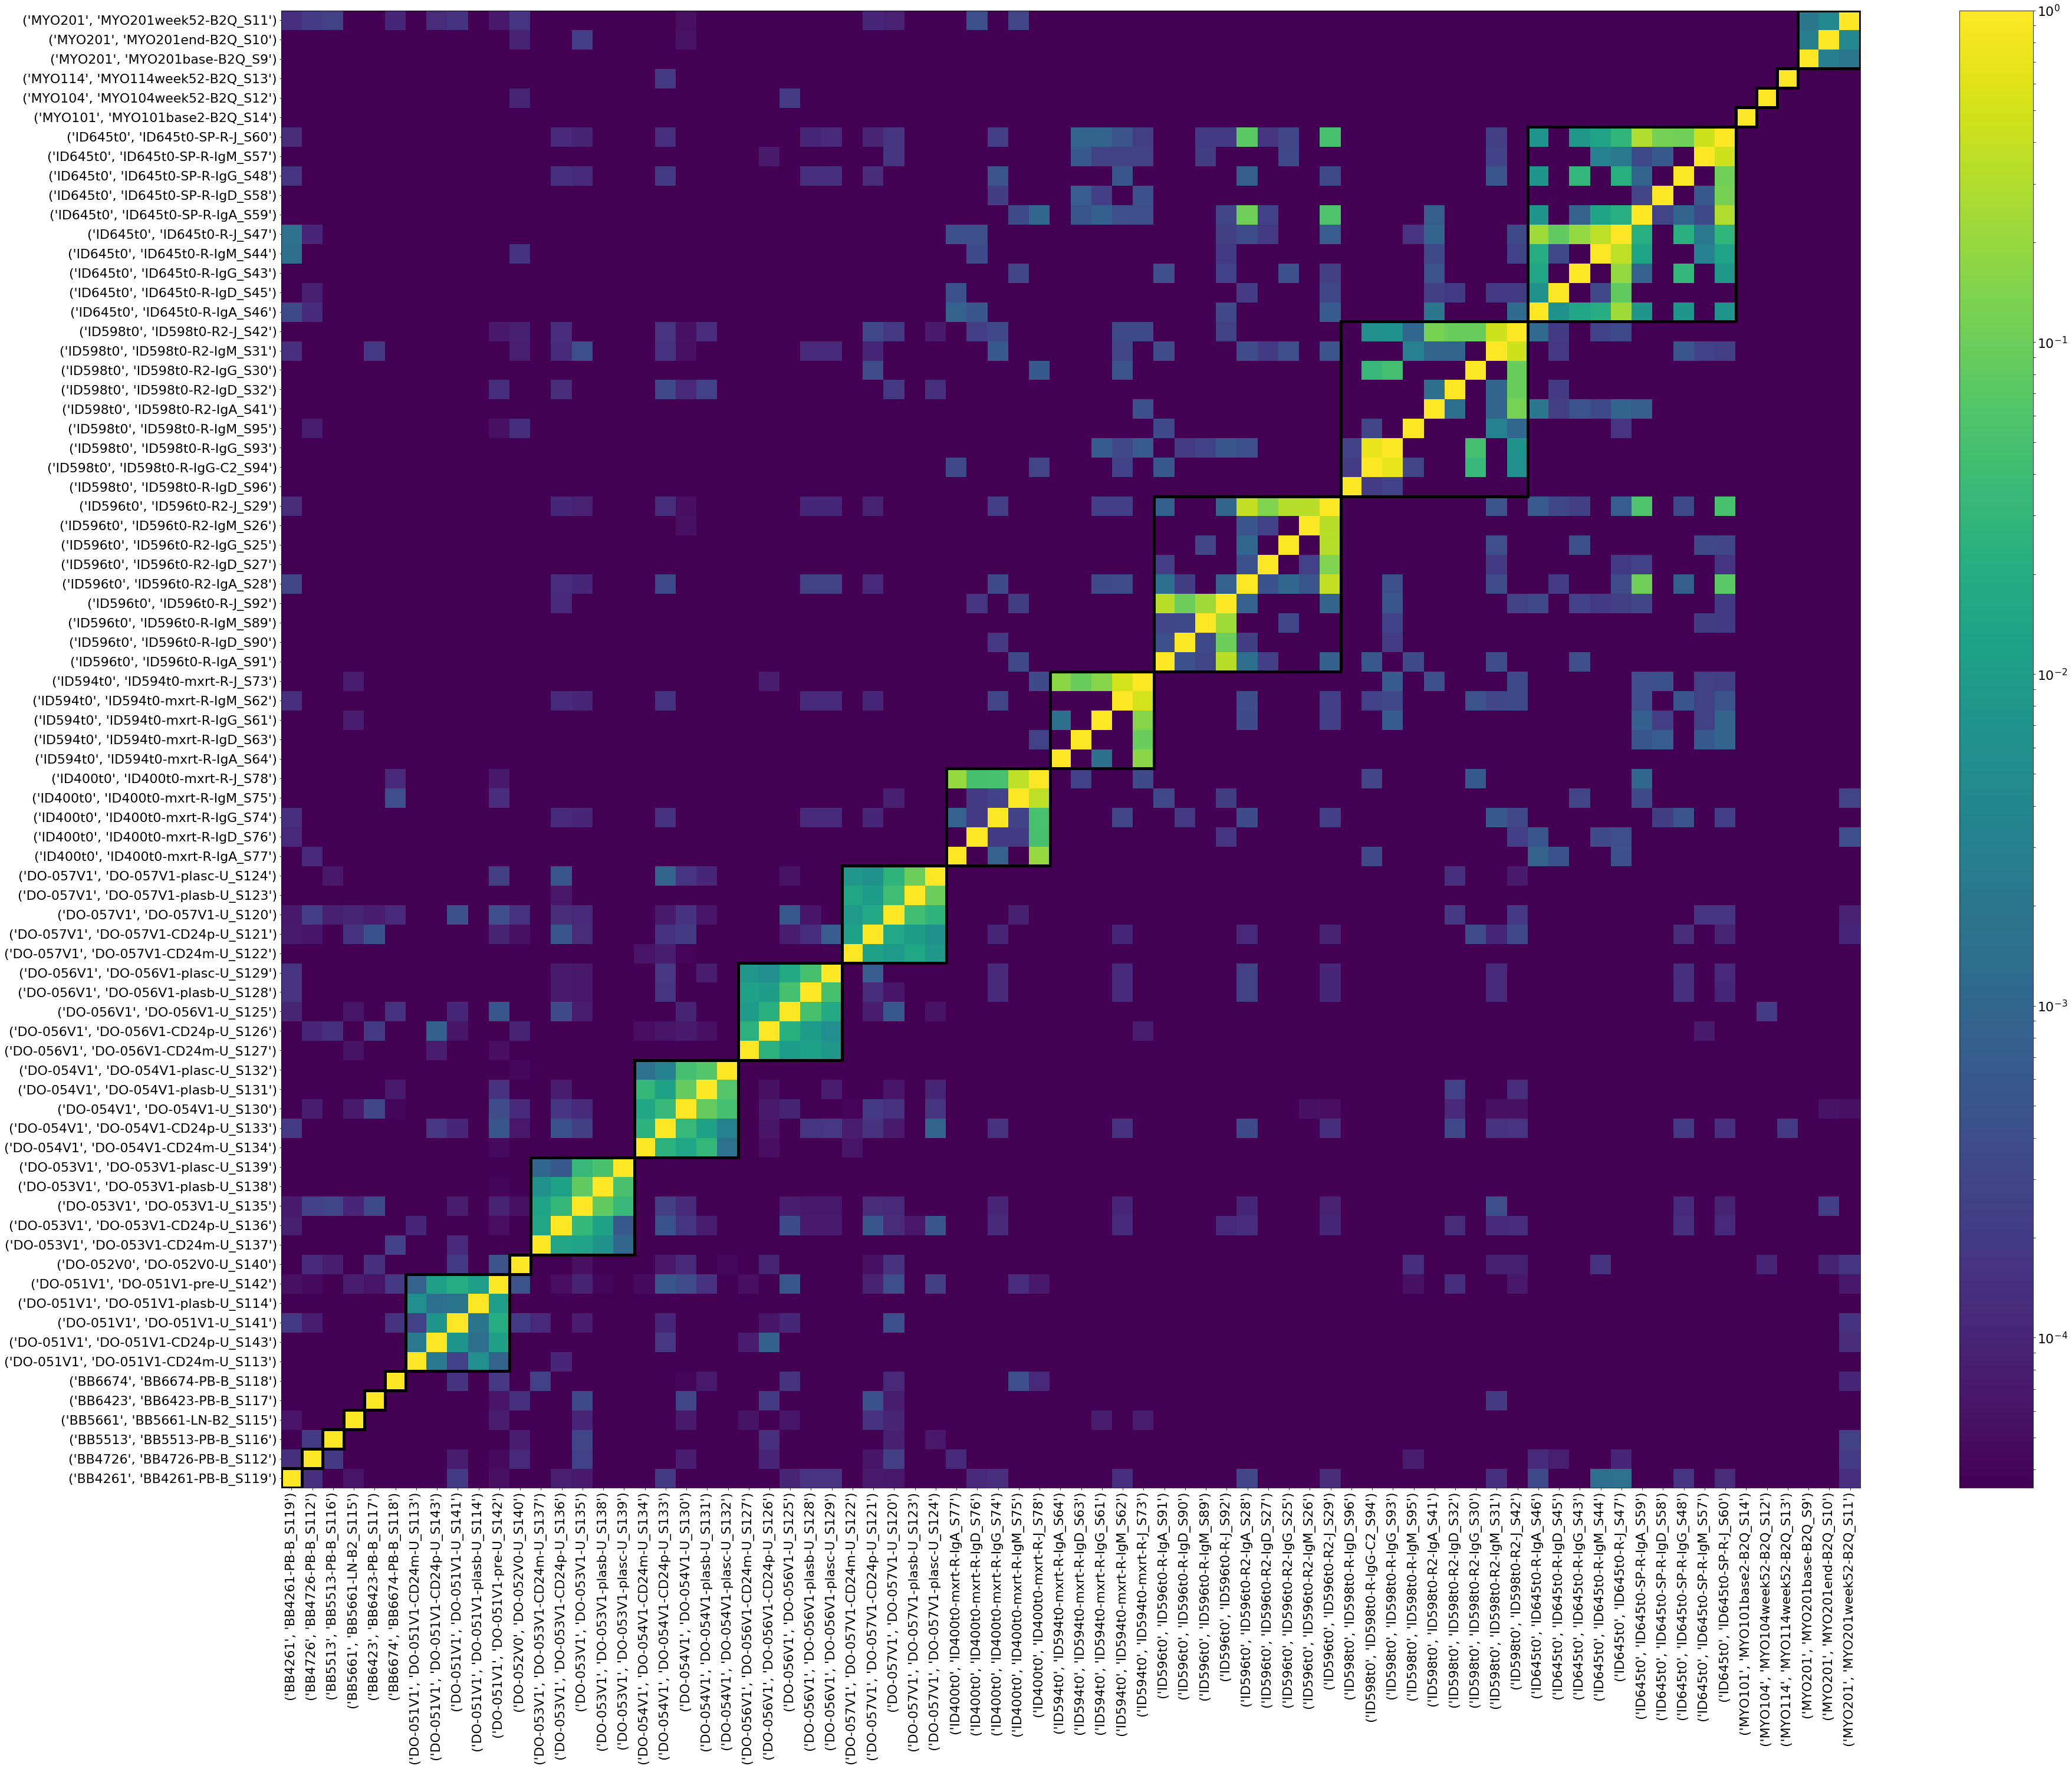

In [16]:
drawHeatmap(sim)

## Highlight anomalies

In [17]:
# get index pairs of same patient (divide same vs not same sample) and list indices for different patients
same_sample = list()
same_patient = list()
diff_patient = list()
for x in sim.index:
    for y in sim.columns:
        if x[0] == y[0]:  # same patient
            if x[1] == y[1]:  # same sample
                same_sample.append((x, y))
            else:        # same patient, but not same sample
                same_patient.append((x, y))
        else:             # not same patient
            diff_patient.append((x,y))                    

In [18]:
# Get values of same patient (but different samples) and values for different patients
values_same_patient = [sim.loc[x][y] for x,y in same_patient]
values_diff_patient = [sim.loc[x][y] for x,y in diff_patient]
mean_diff_patient = np.mean(values_diff_patient)
std_diff_patient = np.std(values_diff_patient)
threshold = mean_diff_patient + 4 * std_diff_patient
print("mean same patient", np.mean(values_same_patient), np.std(values_same_patient))
print("mean diff patient", mean_diff_patient, std_diff_patient)
print("threshold", threshold)

mean same patient 0.04286951825243212 0.10330268433341713
mean diff patient 0.00016896968431453967 0.0028846666915521057
threshold 0.011707636450522963


{'whiskers': [<matplotlib.lines.Line2D at 0x7fa1d8d60a58>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa1d8ce7358>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa1d8d60908>,
 'medians': [<matplotlib.lines.Line2D at 0x7fa1d8ce7ba8>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fa1d8ce7fd0>,
 'means': []}

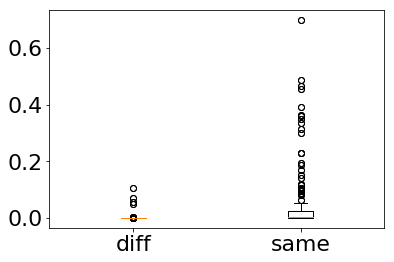

In [19]:
# Boxplot
plt.boxplot([values_diff_patient, values_same_patient], labels=['diff', 'same'])

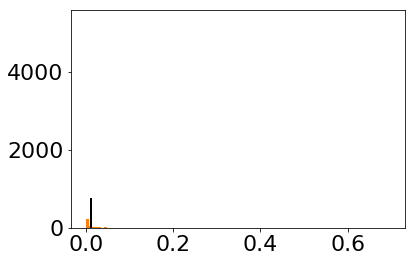

In [20]:
# Histogram
plt.hist(values_diff_patient, bins=100)
plt.hist(values_same_patient, bins=100)
plt.plot([threshold, threshold], [0, 750], 'k-', lw=2)

In [21]:
# Print sample names if similarity is twice the 95% interval
fhOut = open(suspects_list, "w")
check_samples = list()
for i,j in diff_patient:
    if sim.loc[i][j] > threshold:
        print(i, j, sim.loc[i][j])
        print(i, j, sim.loc[i][j], file=fhOut)
        check_samples.append((i,j))
fhOut.close()
print("Wrote", suspects_list, "to disk")

('ID596t0', 'ID596t0-R2-IgA_S28') ('ID645t0', 'ID645t0-SP-R-IgA_S59') 0.10592553749344524
('ID596t0', 'ID596t0-R2-IgA_S28') ('ID645t0', 'ID645t0-SP-R-J_S60') 0.07126279863481233
('ID596t0', 'ID596t0-R2-J_S29') ('ID645t0', 'ID645t0-SP-R-IgA_S59') 0.057697800628391915
('ID596t0', 'ID596t0-R2-J_S29') ('ID645t0', 'ID645t0-SP-R-J_S60') 0.0504137734233806
('ID645t0', 'ID645t0-SP-R-IgA_S59') ('ID596t0', 'ID596t0-R2-IgA_S28') 0.10592553749344524
('ID645t0', 'ID645t0-SP-R-IgA_S59') ('ID596t0', 'ID596t0-R2-J_S29') 0.057697800628391915
('ID645t0', 'ID645t0-SP-R-J_S60') ('ID596t0', 'ID596t0-R2-IgA_S28') 0.07126279863481233
('ID645t0', 'ID645t0-SP-R-J_S60') ('ID596t0', 'ID596t0-R2-J_S29') 0.0504137734233806
Wrote run42-similarity-IGH_HUMAN.txt to disk


In [22]:
sim2 = sim.copy()
for i, j in check_samples:
    sim2.loc[i][j] = 1

min value: 3.524912317809381e-05
max value: 1.0
Wrote run42-similarity-IGH_HUMAN-highlighted.pdf to disk


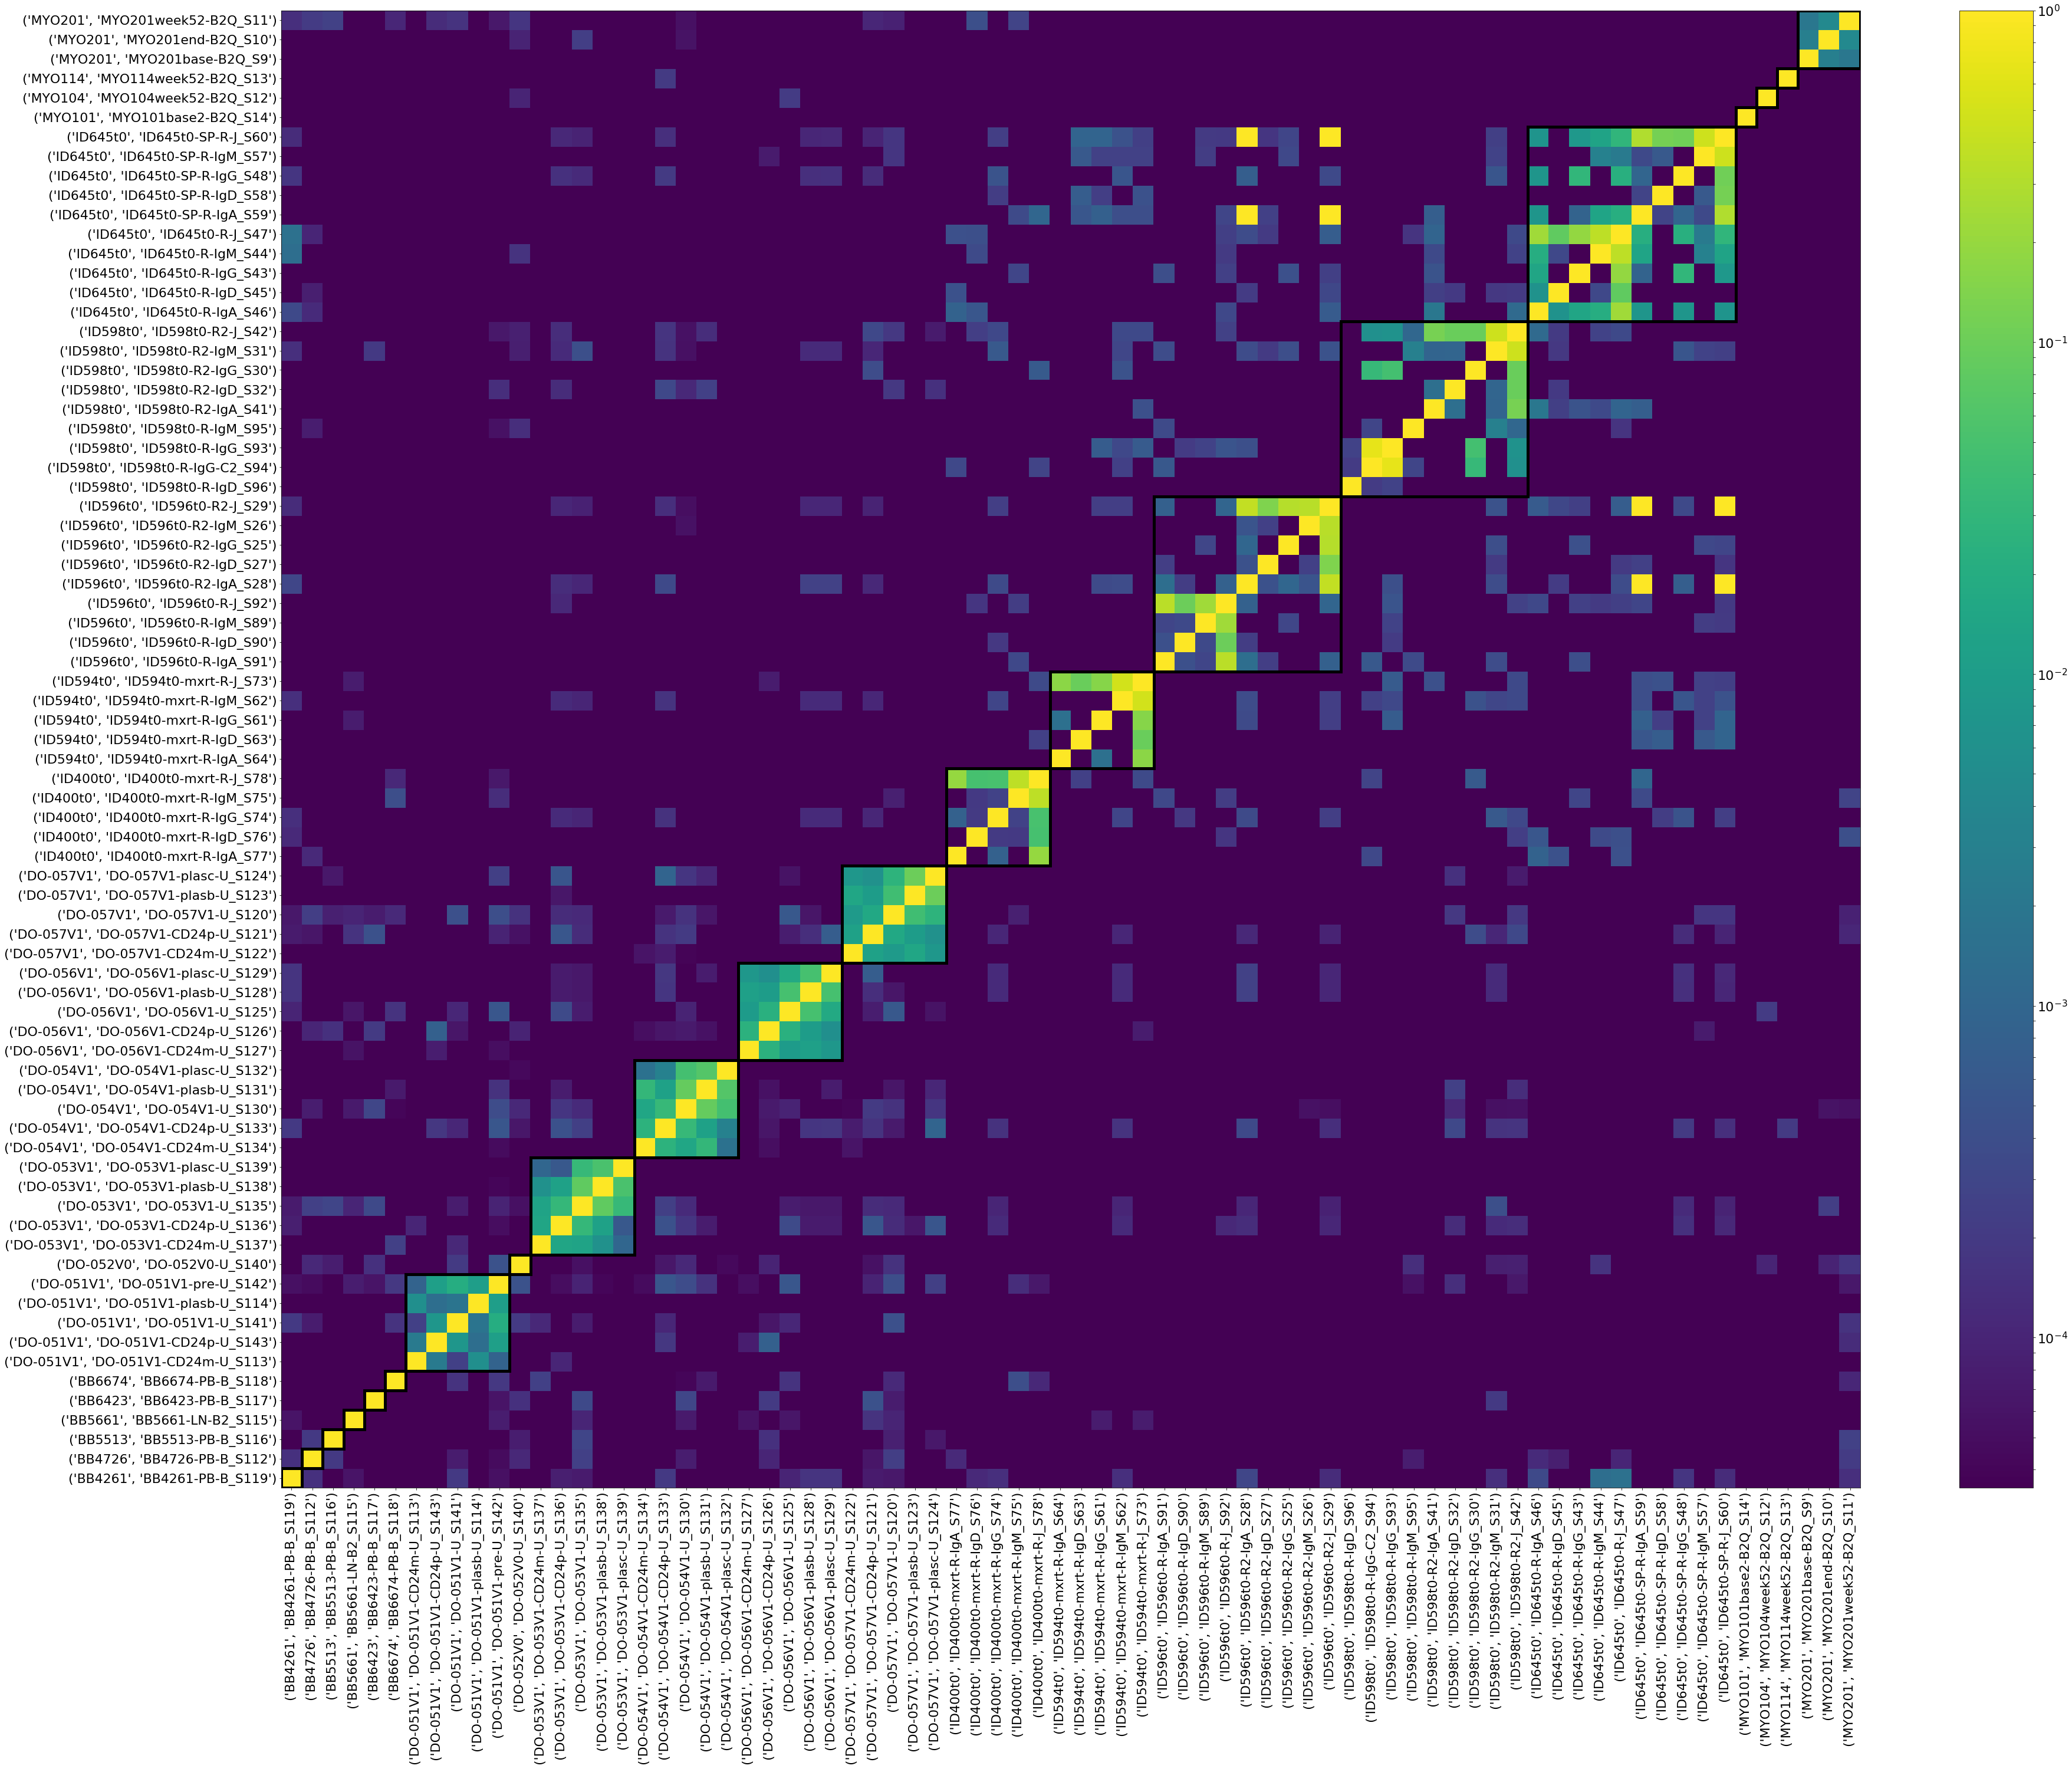

In [23]:
plotfile = plotfile.replace('.pdf', '-highlighted.pdf')
drawHeatmap(sim2)